In [1]:
# ...existing code...
import joblib
from pathlib import Path
import subprocess, sys

try:
    ROOT = Path(subprocess.check_output(["git","rev-parse","--show-toplevel"], text=True).strip())
except Exception:
    ROOT = Path.cwd().resolve().parent  # experiments/ -> repo root

# Make repo packages (e.g., `pipeline`) importable for unpickling
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))

# (optional) pre-import the class’ module used in the pickle
# from pipeline.algo1 import Algo1Outputs

artifact = ROOT / "outputs" / "artifacts" / "algo1_outs_2025-05-22_1min_agreg.pkl"
outs = joblib.load(artifact)
print("Loaded:", artifact)
# ...existing code...

Loaded: /Users/167011/Documents/GitHub/deribit_market_model/outputs/artifacts/algo1_outs_2025-05-22_1min_agreg.pkl


In [2]:
import torch
from neural_sde.constraints import compute_factor_polytope_vertices, assemble_Wb_for_shrinkage, build_factor_path, calc_diffusion_scaling
from neural_sde.nets import NeuralSDEWithShrink                       # [neural_sde/nets.py](neural_sde/nets.py)
from neural_sde.loss import likelihood_training, build_xi_training_data                        # [neural_sde/loss.py](neural_sde/loss.py)
import numpy as np

torch.manual_seed(80085) 

poly = compute_factor_polytope_vertices(
    outs,
    xi_builder=None,      # or None if Xi_*_train are on outs
    k_box=6.0,
    verbose=False,
    return_mappings=True,
)

# 2) Assemble (W,b) for shrinkage and row-normalise
W, b = assemble_Wb_for_shrinkage(poly, include_box=True)

# 3) Build factor path X and its single-step differences dX (align shapes)
X  = build_factor_path(outs, xi_builder=None)          # shape (T, p)
dX = np.diff(X, axis=0)                                      # shape (T-1, p)
X  = X[:-1]                                                  # align to dX

# 4) Choose shrinkage hyperparams (tune these)
# --- Calibrate dist_multiplier to hit epsilon/proj_scale = 0.95
frac_critical_threshold = 0.9
critical_value = 0.95
proj_scale = 0.9

# distances to halfspaces (W rows must be unit-norm already)
dist_X = np.abs(W @ X.T - b[:, None])               # (n_faces, T)
per_face_max = np.max(dist_X, axis=1)               # (n_faces,)
critical_threshold = frac_critical_threshold * np.min(per_face_max)
dist_multiplier = (1.0/(1.0 - critical_value) - 1.0) / critical_threshold

# 5) Compute adaptive diffusion shrinkage terms for train
Omegas, det_Omega, proj_dX = calc_diffusion_scaling(
    W=W, b=b, X=X, dX=dX,
    dist_multiplier=dist_multiplier,
    proj_scale=proj_scale
)


# Compute adaptive diffusion shrinkage terms for test
_, X_te, _ = build_xi_training_data(outs)  # or your builder returning test too
dX_te = np.diff(X_te, axis=0); X_te = X_te[:-1]
Omegas_te, det_Omega_te, proj_dX_te = calc_diffusion_scaling(
    W=W, b=b, X=X_te, dX=dX_te,
    dist_multiplier=dist_multiplier,
    proj_scale=proj_scale
)




100%|██████████| 338/338 [00:00<00:00, 30344.07it/s]


Epoch 1/1000  Train NLL: 4.0620e+01  Test NLL: 4.1758e+01
Epoch 2/1000  Train NLL: 3.3416e+01  Test NLL: 3.4363e+01
Epoch 3/1000  Train NLL: 2.6951e+01  Test NLL: 2.7732e+01
Epoch 4/1000  Train NLL: 2.1143e+01  Test NLL: 2.1779e+01
Epoch 5/1000  Train NLL: 1.5981e+01  Test NLL: 1.6491e+01
Epoch 6/1000  Train NLL: 1.1403e+01  Test NLL: 1.1810e+01
Epoch 7/1000  Train NLL: 7.3783e+00  Test NLL: 7.7009e+00
Epoch 8/1000  Train NLL: 3.9051e+00  Test NLL: 4.1520e+00
Epoch 9/1000  Train NLL: 9.4841e-01  Test NLL: 1.1272e+00
Epoch 10/1000  Train NLL: -1.5213e+00  Test NLL: -1.4043e+00
Epoch 11/1000  Train NLL: -3.5205e+00  Test NLL: -3.4598e+00
Epoch 12/1000  Train NLL: -5.0648e+00  Test NLL: -5.0578e+00
Epoch 13/1000  Train NLL: -6.1559e+00  Test NLL: -6.1961e+00
Epoch 14/1000  Train NLL: -6.8177e+00  Test NLL: -6.8992e+00
Epoch 15/1000  Train NLL: -7.0655e+00  Test NLL: -7.1918e+00
Epoch 16/1000  Train NLL: -7.1132e+00  Test NLL: -7.2786e+00
Epoch 17/1000  Train NLL: -7.2515e+00  Test NLL: -7

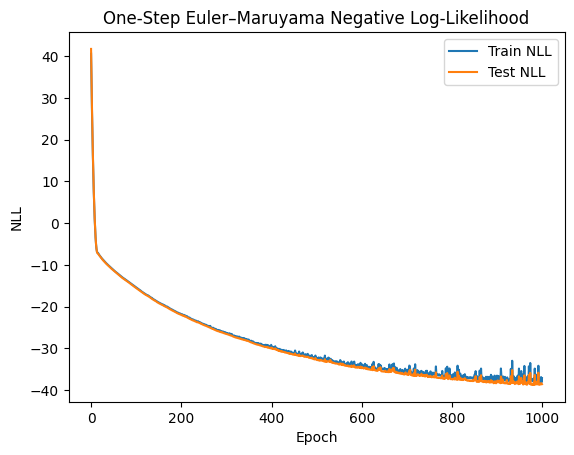

In [3]:
torch.manual_seed(80085) 

train_losses, test_losses, model, X_train = likelihood_training(
    outs,
    Omega_tr=Omegas,
    det_Omega_tr = det_Omega,
    proj_dX_tr=proj_dX,
    Omega_te = Omegas_te,
    det_Omega_te = det_Omega_te,
    proj_dX_te = proj_dX_te,
    n_epochs=1000,
    batch_size=256,
    lr=5e-5,
    data='xi',
    zero_drift=False,
    model = None
)

import matplotlib.pyplot as plt
plt.figure()
plt.plot(train_losses, label="Train NLL")
plt.plot(test_losses, label="Test NLL")
plt.title("One-Step Euler–Maruyama Negative Log-Likelihood")
plt.xlabel("Epoch")
plt.ylabel("NLL")
plt.legend()
plt.show()

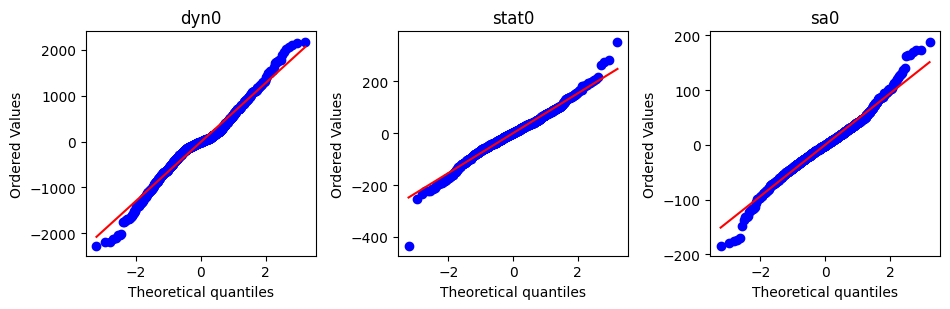

In [5]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from scipy import stats
from neural_sde.loss import build_xi_training_data  # -> [`neural_sde.loss.build_xi_training_data`](neural_sde/loss.py)

sde_model = model

sec_per_year = 365*24*60*60

# 1) In-sample factor matrix (columns = factors: dyn | stat | sa)
X_train, _, names = build_xi_training_data(outs)  # names like ["dyn0","dyn1",...,"stat0",...,"sa0",...]

# 2) Compute dt in years from training timestamps (align lengths)
tt = pd.to_datetime(outs.C_train.index.values)
# sec_per_year = 1
dt = np.asarray((tt[1:] - tt[:-1]).total_seconds(), dtype=np.float64) / sec_per_year

L = min(len(dt), X_train.shape[0]-1)

device = next(sde_model.parameters()).device
Y0 = torch.from_numpy(X_train[:L]).float().to(device)
Y1 = torch.from_numpy(X_train[1:L+1]).float().to(device)
dt_t = torch.from_numpy(dt[:L].copy()).float().unsqueeze(1).clamp_min(1e-12).to(device)

with torch.no_grad():
    mu  = sde_model.f(0.0, Y0)
    sig = sde_model.g(0.0, Y0).clamp_min(1e-9)
    eps = (Y1 - Y0 - mu*dt_t) / (sig * torch.sqrt(dt_t))
resid = eps.cpu().numpy()

# 3) One-step standardized residuals under the trained SDE
#    ε_t = (x_{t+1} - x_t - f(x_t)Δt) / (g(x_t)√Δt)
with torch.no_grad():
    mu = sde_model.f(0.0, Y0)                        # [`neural_sde.nets.NeuralSDE.f`](neural_sde/nets.py)
    sig = sde_model.g(0.0, Y0).clamp_min(1e-9)       # [`neural_sde.nets.NeuralSDE.g`](neural_sde/nets.py)
    eps = (Y1 - Y0 - mu*dt_t) / (sig * torch.sqrt(dt_t))
resid = eps.cpu().numpy()

# 4) QQ plots per factor
d = resid.shape[1]
cols = 3
rows = int(np.ceil(d/cols))
fig, axes = plt.subplots(rows, cols, figsize=(cols*3.2, rows*3.2))
axes = axes.ravel()

for j in range(d):
    stats.probplot(resid[:, j], dist="norm", plot=axes[j])
    axes[j].set_title(names[j] if names else f"factor {j}")

for k in range(d, len(axes)):
    axes[k].axis("off")

plt.tight_layout()
plt.show()



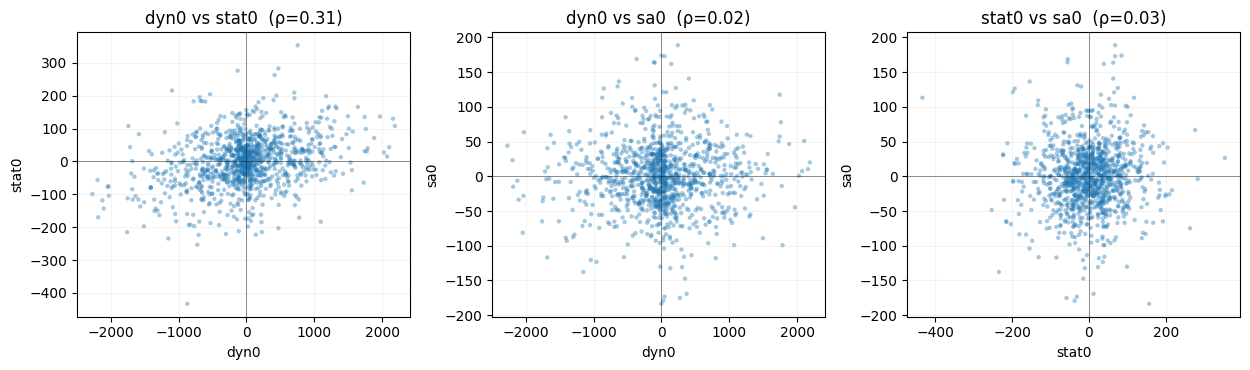

In [6]:
# Pairwise scatter plots of residuals
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
import math

R = np.asarray(resid, float)  # shape (T-1, d)
d = R.shape[1]
labels = names if (isinstance(names, (list, tuple)) and len(names)==d) else [f"f{j}" for j in range(d)]

pairs = list(combinations(range(d), 2))
cols = min(3, len(pairs))
rows = math.ceil(len(pairs) / cols)
fig, axes = plt.subplots(rows, cols, figsize=(cols*4.2, rows*3.8), squeeze=False)

for ax, (i, j) in zip(axes.ravel(), pairs):
    x, y = R[:, i], R[:, j]
    rho = np.corrcoef(x, y)[0, 1]
    ax.scatter(x, y, s=10, alpha=0.4, edgecolors="none")
    ax.axhline(0, color="k", lw=0.5, alpha=0.6)
    ax.axvline(0, color="k", lw=0.5, alpha=0.6)
    ax.set_xlabel(labels[i]); ax.set_ylabel(labels[j])
    ax.set_title(f"{labels[i]} vs {labels[j]}  (ρ={rho:.2f})")
    ax.grid(alpha=0.15)

# hide any unused axes
for k in range(len(pairs), rows*cols):
    fig.delaxes(axes.ravel()[k])

plt.tight_layout()
plt.show()


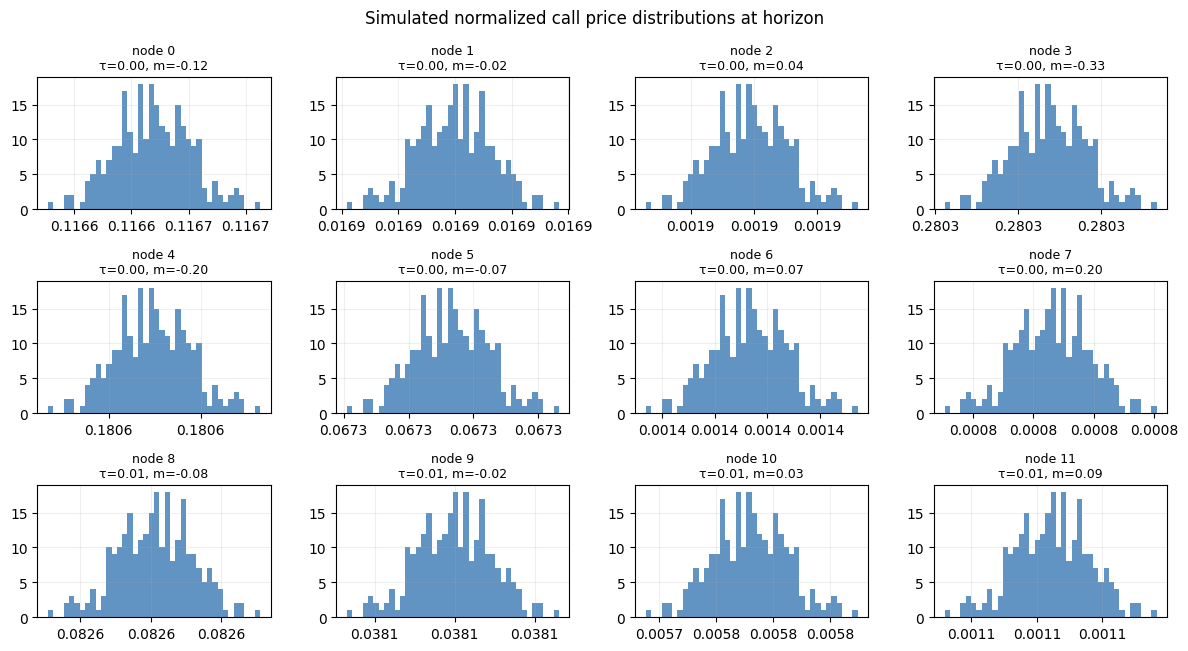

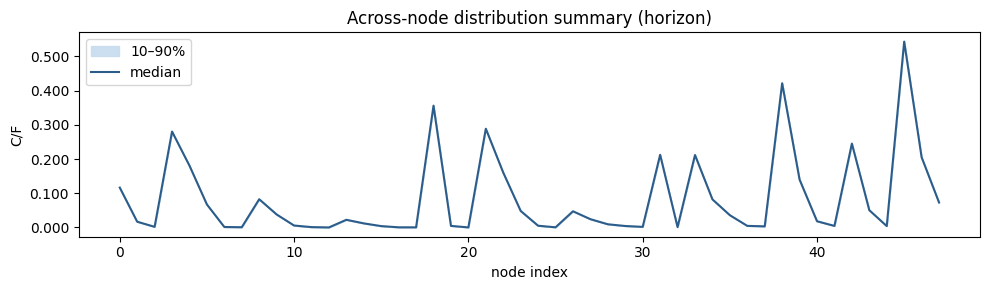

In [7]:
# Requires:
# - outs from decoding (Algo1Outputs, e.g. from decoding_aggre.ipynb)
# - model from neural_sde training (e.g. likelihood_training)
# Optional:
# - mu, sd returned by likelihood_training if standardisation was used

import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from neural_sde.loss import build_xi_training_data  # -> [`neural_sde.loss.build_xi_training_data`](neural_sde/loss.py)

device = next(model.parameters()).device

# 1) Factor dimension and helper to split [dyn|stat|sa] blocks (order matches build_xi_training_data)
k_dyn  = outs.G_dyn.shape[0] if getattr(outs, "G_dyn", None) is not None and outs.G_dyn.size else 0
k_stat = outs.G_stat.shape[0] if getattr(outs, "G_stat", None) is not None and outs.G_stat.size else 0
k_sa   = outs.G_sa.shape[0]   if getattr(outs, "G_sa",   None) is not None and outs.G_sa.size   else 0
p = k_dyn + k_stat + k_sa
N = outs.G0.shape[0]  # number of nodes

def split_blocks(x):
    """x: (..., p) -> (xd, xs, xa)"""
    i = 0
    xd = x[..., i:i+k_dyn];  i += k_dyn
    xs = x[..., i:i+k_stat]; i += k_stat
    xa = x[..., i:i+k_sa] if k_sa>0 else x[..., :0]
    return xd, xs, xa

# 2) Build train factors (for x0) and dt (years)
X_tr, _, names = build_xi_training_data(outs)
x0_raw = X_tr[-1].astype(np.float64)  # last observed state as start

sec_per_year = 365.0*24*3600
tt_tr = pd.to_datetime(outs.C_train.index.values)
dt_tr = np.asarray((tt_tr[1:] - tt_tr[:-1]).total_seconds(), dtype=np.float64) / sec_per_year
dt = float(np.median(dt_tr)) if len(dt_tr) else (1.0/365/24/60)  # ~1 minute fallback

# 3) Prepare standardisation if available (depends on your likelihood_training return)
def to_model_space(x):
    if 'mu' in globals() and 'sd' in globals() and (mu is not None) and (sd is not None):
        mu_np = mu.detach().cpu().numpy() if torch.is_tensor(mu) else np.asarray(mu)
        sd_np = sd.detach().cpu().numpy() if torch.is_tensor(sd) else np.asarray(sd)
        return (x - mu_np.ravel()) / (sd_np.ravel() + 1e-9)
    return x

def from_model_space(x):
    if 'mu' in globals() and 'sd' in globals() and (mu is not None) and (sd is not None):
        mu_np = mu.detach().cpu().numpy() if torch.is_tensor(mu) else np.asarray(mu)
        sd_np = sd.detach().cpu().numpy() if torch.is_tensor(sd) else np.asarray(sd)
        return x * sd_np.ravel() + mu_np.ravel()
    return x

# 4) Euler–Maruyama simulation for factors under [`neural_sde.nets.NeuralSDE`](neural_sde/nets.py)
@torch.no_grad()
def simulate_factors(model, x0_raw, n_steps=60, n_paths=256, dt_years=dt, clamp_sig=1e-9):
    x0 = to_model_space(x0_raw.astype(np.float64))
    x  = torch.from_numpy(np.tile(x0, (n_paths, 1))).float().to(device)  # (B, p)
    out = [x.clone()]
    DT = torch.tensor(dt_years, dtype=torch.float32, device=device).view(1,1)
    for _ in range(n_steps):
        mu  = model.f(0.0, x)
        sig = model.g(0.0, x).clamp_min(clamp_sig)        # diagonal diffusion per-dim
        eps = torch.randn_like(x)
        x   = x + mu*DT + sig*torch.sqrt(DT)*eps
        out.append(x.clone())
    X_std = torch.stack(out, dim=1)  # (B, T+1, p)
    X_raw = from_model_space(X_std.cpu().numpy())
    return X_raw  # numpy (n_paths, n_steps+1, p)

# 5) Map factors -> normalized option prices at each lattice node
#    C = G0 + Xi_dyn·G_dyn + Xi_stat·G_stat + Xi_sa·G_sa  (see [`factors.decode.reconstruct_prices`](factors/decode.py))
def factors_to_prices(X):
    """
    X: (B, T+1, p) in raw Xi space
    Returns: C: (B, T+1, N) normalized prices per node
    """
    B, T1, _ = X.shape
    C = np.empty((B, T1, N), dtype=np.float64)
    G0 = outs.G0.astype(np.float64)
    Gd = outs.G_dyn.astype(np.float64) if k_dyn>0 else np.zeros((0, N))
    Gs = outs.G_stat.astype(np.float64) if k_stat>0 else np.zeros((0, N))
    Ga = outs.G_sa.astype(np.float64)   if k_sa>0   else np.zeros((0, N))
    for t in range(T1):
        xt = X[:, t, :]                    # (B, p)
        xd, xs, xa = split_blocks(xt)      # (B,k_*)
        C[:, t, :] = (G0[None, :]
                      + (xd @ Gd) if k_dyn>0 else 0.0
                      + (xs @ Gs) if k_stat>0 else 0.0
                      + (xa @ Ga) if k_sa>0   else 0.0)
    # Optional no‑arb clipping to [max(1-exp(m),0), 1]
    m = outs.nodes_sub[:, 1].astype(np.float64)
    lb = np.maximum(1.0 - np.exp(m), 0.0)
    C = np.clip(C, lb[None, None, :], 1.0)
    return C

# 6) Run simulation and get price distribution at horizon
n_paths = 256
n_steps = 60   # horizon steps (~60 minutes if dt is 1 minute)
X_sim = simulate_factors(model, x0_raw, n_steps=n_steps, n_paths=n_paths, dt_years=dt)
C_sim = factors_to_prices(X_sim)   # (B, T+1, N)

# Choose horizon snapshot (final time)
C_T = C_sim[:, -1, :]              # (B, N)

from matplotlib.ticker import ScalarFormatter, FormatStrFormatter

def tidy_x_axis(ax, data):
    # turn off offset/scientific notation
    ax.ticklabel_format(axis="x", style="plain", useOffset=False)
    ax.get_xaxis().get_offset_text().set_visible(False)
    # choose a readable fixed-decimal formatter based on range
    rng = float(np.ptp(data))
    if rng < 0.02:
        fmt = FormatStrFormatter('%.4f')
    elif rng < 0.2:
        fmt = FormatStrFormatter('%.3f')
    else:
        fmt = FormatStrFormatter('%.2f')
    ax.xaxis.set_major_formatter(fmt)

# 7) Visualise: histograms for first 12 nodes and a violin summary
n_show = min(12, C_T.shape[1])
fig, axes = plt.subplots(int(np.ceil(n_show/4)), 4, figsize=(12, 2.2*np.ceil(n_show/4)), squeeze=False)
axes = axes.ravel()
for j in range(n_show):
    ax = axes[j]
    ax.hist(C_T[:, j], bins=40, alpha=0.8, color="#3a78b4")
    τ, m = outs.nodes_sub[j, 0], outs.nodes_sub[j, 1]
    tidy_x_axis(ax, C_T[:, j])
    ax.set_title(f"node {j}\nτ={τ:.2f}, m={m:.2f}", fontsize=9)
    ax.grid(alpha=0.2)
for k in range(n_show, len(axes)):
    fig.delaxes(axes[k])
fig.suptitle("Simulated normalized call price distributions at horizon", y=0.98)
plt.tight_layout(); plt.show()

# Violin summary: also remove offset on y (prices)
plt.figure(figsize=(10,3))
q_lo, q_md, q_hi = np.quantile(C_T, [0.1, 0.5, 0.9], axis=0)
plt.fill_between(np.arange(N), q_lo, q_hi, color="#c7dcef", alpha=0.9, label="10–90%")
plt.plot(q_md, color="#2c5d8a", lw=1.5, label="median")
ax = plt.gca()
ax.ticklabel_format(axis="y", style="plain", useOffset=False)
ax.get_yaxis().get_offset_text().set_visible(False)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
plt.title("Across-node distribution summary (horizon)"); plt.xlabel("node index"); plt.ylabel("C/F")
plt.legend(); plt.tight_layout(); plt.show()


             portfolio  alpha       VaR      CVaR      mean_PnL   std_PnL  \
0   1x2x1 Call Fly ~1d   0.95  0.000022  0.000028  1.684150e-06  0.000015   
1         Long ATM ~1d   0.95  0.000003  0.000004 -1.894102e-07  0.000002   
2  Short OTM +0.10 ~1d   0.95  0.000002  0.000002  1.247927e-07  0.000001   
3   1x2x1 Call Fly ~1d   0.99  0.000033  0.000036  1.684150e-06  0.000015   
4         Long ATM ~1d   0.99  0.000004  0.000005 -1.894102e-07  0.000002   
5  Short OTM +0.10 ~1d   0.99  0.000002  0.000003  1.247927e-07  0.000001   

   notional_abs_sum  
0               4.0  
1               1.0  
2               1.0  
3               4.0  
4               1.0  
5               1.0  


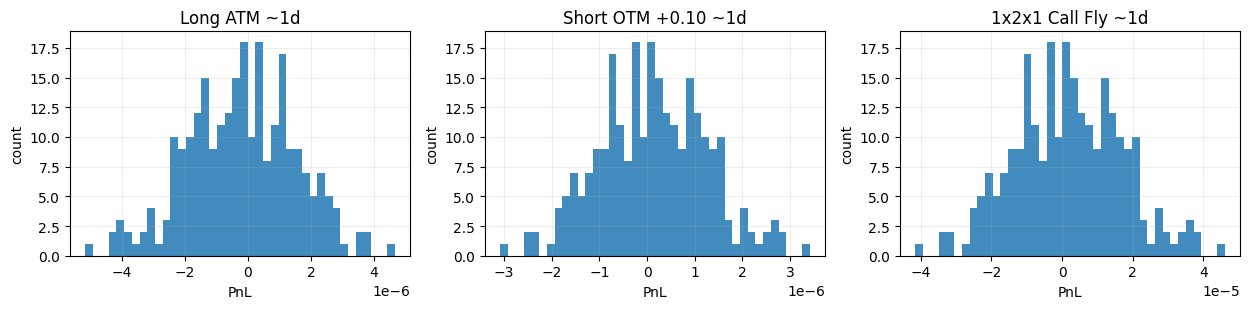

In [8]:
def portfolio_var_from_C(C_sim, q, F0=1.0, multipliers=None, alpha=0.99):
    """
    C_sim: (B, T+1, N) normalized prices C/F
    q:     (N,) portfolio holdings per node
    F0:    scalar forward at t0 to convert to dollars (use 1.0 to stay normalized)
    multipliers: (N,) contract multipliers (default 1.0)
    """
    C_sim = np.asarray(C_sim)
    q = np.asarray(q).reshape(-1)
    B, T1, N = C_sim.shape
    assert q.shape[0] == N, "q must match number of nodes"

    w = np.ones(N) if multipliers is None else np.asarray(multipliers).reshape(-1)
    notional = q * F0 * w  # (N,)

    V0 = C_sim[:, 0, :] @ notional      # (B,)
    VT = C_sim[:, -1, :] @ notional     # (B,)
    dV = VT - V0                        # (B,)

    qtile = np.quantile(dV, 1 - alpha)
    var   = -qtile
    cvar  = -dV[dV <= qtile].mean()
    return var, cvar, dV


# ------------------------------------------------------------
# Helpers: map specs -> q vectors
# ------------------------------------------------------------
def nearest_node_index(tau, m, nodes):
    """
    nodes: array of shape (N,2) with columns [tau, m]
    returns index j of the nearest node by Euclidean distance in (tau, m).
    """
    diffs = nodes - np.array([tau, m])[None, :]
    j = np.argmin(np.sum(diffs*diffs, axis=1))
    return int(j)

def make_q_from_spec(spec, nodes):
    """
    Build q vector (N,) from a portfolio spec.
    spec can be:
      - dict {int_node_index: qty, ...}
      - list of (tau, m, qty) tuples (mapped to nearest node)
    """
    N = nodes.shape[0]
    q = np.zeros(N, dtype=float)
    if isinstance(spec, dict):
        for j, qty in spec.items():
            q[int(j)] += float(qty)
        return q

    # assume iterable of (tau, m, qty)
    for tau, m, qty in spec:
        j = nearest_node_index(float(tau), float(m), nodes)
        q[j] += float(qty)
    return q

# ------------------------------------------------------------
# Bulk evaluation
# ------------------------------------------------------------
def evaluate_var_for_portfolios(C_sim, portfolios, nodes, F0=1.0, multipliers=None, alphas=(0.99,)):
    """
    portfolios: dict name -> spec (dict of {node_index: qty} OR list of (tau, m, qty))
    returns: (summary_df, details) where:
      - summary_df: tidy table with VaR/CVaR per portfolio & alpha
      - details: dict name -> dict { 'q': q, 'PnL': dV }
    """
    results = []
    details = {}
    for name, spec in portfolios.items():
        q = make_q_from_spec(spec, nodes)
        # compute once, then grab for all alphas
        _, _, dV = portfolio_var_from_C(C_sim, q, F0=F0, multipliers=multipliers, alpha=alphas[0])
        details[name] = {'q': q, 'PnL': dV}

        for a in alphas:
            var_a, cvar_a, _ = portfolio_var_from_C(C_sim, q, F0=F0, multipliers=multipliers, alpha=a)
            results.append({
                'portfolio': name,
                'alpha': a,
                'VaR': var_a,
                'CVaR': cvar_a,
                'mean_PnL': float(np.mean(dV)),
                'std_PnL': float(np.std(dV, ddof=1)),
                'notional_abs_sum': float(np.sum(np.abs(q)))  # in normalized units unless F0/multipliers used
            })

    summary = pd.DataFrame(results).sort_values(['alpha','VaR'], ascending=[True, False]).reset_index(drop=True)
    return summary, details

# ------------------------------------------------------------
# Example portfolio set
# nodes_2d should be your (tau, m) for each lattice node.
# Prefer outs.nodes_sub if present, else outs.nodes.
# ------------------------------------------------------------
nodes_2d = getattr(outs, 'nodes_sub', getattr(outs, 'nodes_sub'))
assert nodes_2d.shape[1] == 2, "nodes must have shape (N,2) with [tau, m]"

# Build a few example portfolios (edit to your needs):
tau_near_1d = 1.0/365.0
tau_near_3d = 3.0/365.0
m_atm       = 0.0
m_otm_up    = +0.10
m_otm_dn    = -0.10

portfolios = {
    # 1) Long single near-ATM call (by (tau,m))
    "Long ATM ~1d": [
        (tau_near_1d, m_atm, +1.0)
    ],

    # 2) Short OTM ~1d
    "Short OTM +0.10 ~1d": [
        (tau_near_1d, m_otm_up, -1.0)
    ],

    # 3) Call butterfly around ATM at ~1d: +1 at m=-0.10, -2 at m=0, +1 at m=+0.10
    "1x2x1 Call Fly ~1d": [
        (tau_near_1d, m_otm_dn, +1.0),
        (tau_near_1d, m_atm,    -2.0),
        (tau_near_1d, m_otm_up, +1.0)
    ],
}


# ------------------------------------------------------------
# Run VaR evaluation
# ------------------------------------------------------------
# Choose your conversion to dollars if you want absolute VaR:
# - F0: current forward/spot at t0 (e.g., BTCUSD price)
# - multipliers: contract sizes per node (vector length N) if needed
F0 = 1.0
multipliers = None
alphas = (0.95, 0.99)

summary_df, details = evaluate_var_for_portfolios(
    C_sim=C_sim,
    portfolios=portfolios,
    nodes=nodes_2d,
    F0=F0,
    multipliers=multipliers,
    alphas=alphas
)

print(summary_df)

# ------------------------------------------------------------
# (Optional) quick P&L histogram per portfolio
# ------------------------------------------------------------
import matplotlib.pyplot as plt
cols = len(portfolios)
fig, axes = plt.subplots(1, cols, figsize=(4.2*cols, 3.2), squeeze=False)
for ax, (name, info) in zip(axes.ravel(), details.items()):
    dV = info['PnL']
    ax.hist(dV, bins=40, alpha=0.85)
    ax.set_title(name)
    ax.set_xlabel("PnL")
    ax.set_ylabel("count")
    ax.grid(alpha=0.2)
plt.tight_layout(); plt.show()


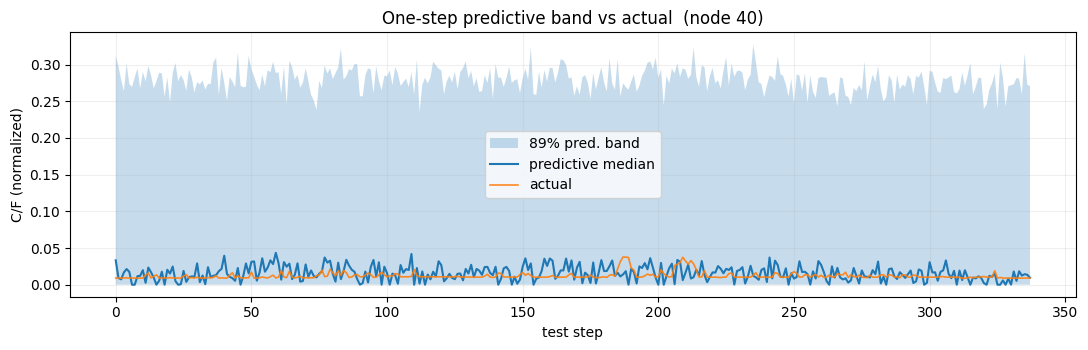

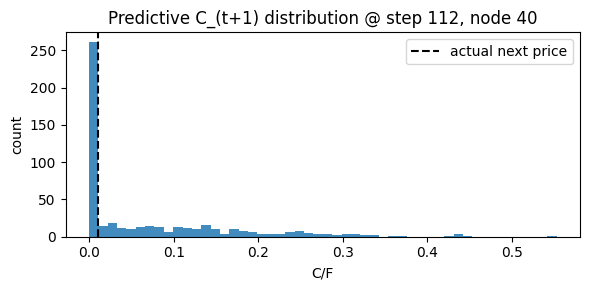

PIT mean (should be ~0.5 if calibrated): 0.4929387019230769


In [9]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

device = next(model.parameters()).device

# ---------------------------
# 1) Factors & dt (TEST SET)
# ---------------------------
# Build test factors in the SAME order as training
_, X_te, names = build_xi_training_data(outs)  # shape (T_test, p)
X_te = X_te.astype(np.float64)
T_test, p = X_te.shape

# Test dt in years from test index
sec_per_year = 1
tt_te = pd.to_datetime(outs.C_test.index.values)
dt_te = np.asarray((tt_te[1:] - tt_te[:-1]).astype('timedelta64[s]'), dtype=np.int64) / sec_per_year
assert len(dt_te) == T_test 

# ---------------------------
# 2) Standardisation hooks
# ---------------------------
def to_model_space(x):
    # if 'mu' in globals() and 'sd' in globals() and (mu is not None) and (sd is not None):
    #     mu_np = mu.detach().cpu().numpy() if torch.is_tensor(mu) else np.asarray(mu)
    #     sd_np = sd.detach().cpu().numpy() if torch.is_tensor(sd) else np.asarray(sd)
    #     return (x - mu_np.ravel()) / (sd_np.ravel() + 1e-9)
    return x

def from_model_space(x):
    # if 'mu' in globals() and 'sd' in globals() and (mu is not None) and (sd is not None):
    #     mu_np = mu.detach().cpu().numpy() if torch.is_tensor(mu) else np.asarray(mu)
    #     sd_np = sd.detach().cpu().numpy() if torch.is_tensor(sd) else np.asarray(sd)
    #     return x * sd_np.ravel() + mu_np.ravel()
    return x

# ---------------------------
# 3) Factors → prices (batch)
# ---------------------------
k_dyn  = outs.G_dyn.shape[0] if getattr(outs, "G_dyn", None) is not None and outs.G_dyn.size else 0
k_stat = outs.G_stat.shape[0] if getattr(outs, "G_stat", None) is not None and outs.G_stat.size else 0
k_sa   = outs.G_sa.shape[0]   if getattr(outs, "G_sa",   None) is not None and outs.G_sa.size   else 0
N = outs.G0.shape[0]

G0 = outs.G0.astype(np.float64)
Gd = outs.G_dyn.astype(np.float64) if k_dyn  > 0 else np.zeros((0, N))
Gs = outs.G_stat.astype(np.float64) if k_stat > 0 else np.zeros((0, N))
Ga = outs.G_sa.astype(np.float64)   if k_sa   > 0 else np.zeros((0, N))

def split_blocks(x):
    i = 0
    xd = x[..., i:i+k_dyn];  i += k_dyn
    xs = x[..., i:i+k_stat]; i += k_stat
    xa = x[..., i:i+k_sa] if k_sa>0 else x[..., :0]
    return xd, xs, xa

def x_to_prices_batch(X_batch):
    """
    X_batch: (B, p) raw Xi → returns (B, N) normalized prices
    """
    xd, xs, xa = split_blocks(X_batch)
    term = np.broadcast_to(G0, (X_batch.shape[0], N)).copy()
    if k_dyn  > 0: term += xd @ Gd
    if k_stat > 0: term += xs @ Gs
    if k_sa   > 0: term += xa @ Ga
    # No-arb clipping
    m = outs.nodes_sub[:, 1].astype(np.float64) if hasattr(outs, 'nodes_sub') else outs.nodes[:,1].astype(np.float64)
    lb = np.maximum(1.0 - np.exp(m), 0.0)
    return np.clip(term, lb[None, :], 1.0)

# ---------------------------
# 4) One-step predictive draw
# ---------------------------
@torch.no_grad()
def one_step_draw_C(model, x0_raw, dt_years, n_paths=512, clamp_sig=1e-9):
    """
    x0_raw: (p,) raw Xi at time t
    dt_years: scalar
    returns: C_{t+1} draws as (n_paths, N)
    """
    x0 = to_model_space(x0_raw.astype(np.float64))
    x  = torch.from_numpy(np.tile(x0, (n_paths, 1))).float().to(device)  # (B, p)
    DT = torch.tensor(dt_years, dtype=torch.float32, device=device).view(1,1)

    mu  = model.f(0.0, x)
    sig = model.g(0.0, x).clamp_min(clamp_sig)   # diagonal diffusion per dim
    eps = torch.randn_like(x)
    x1  = x + mu*DT + sig*torch.sqrt(DT)*eps     # Euler one-step

    X1_raw = from_model_space(x1.detach().cpu().numpy())
    C1     = x_to_prices_batch(X1_raw)           # (n_paths, N)
    return C1

# ---------------------------
# 5) Roll through test set:
#    node overlay and histogram
# ---------------------------
node_idx   = 40              # <- choose the lattice node to evaluate/plot
alpha_band = (0.05, 0.95)   # predictive band

C_actual = outs.C_test.values.astype(np.float64)  # (T_test, N) normalized
assert C_actual.shape[0] == T_test + 1

n_paths = 512
q_lo_series, q_md_series, q_hi_series = [], [], []
actual_series = []
time_index = tt_te[1:]  # we predict t+1

# collect also PIT values if you want calibration later
pit_vals = []

for t in range(T_test - 1):
    C1_draws = one_step_draw_C(model, X_te[t], dt_te[t], n_paths=n_paths)  # (B, N)
    # predictive stats for chosen node
    draws_node = C1_draws[:, node_idx]
    q_lo, q_md, q_hi = np.quantile(draws_node, [alpha_band[0], 0.5, alpha_band[1]])
    q_lo_series.append(q_lo); q_md_series.append(q_md); q_hi_series.append(q_hi)
    actual = C_actual[t+1, node_idx]
    actual_series.append(actual)
    # PIT
    pit_vals.append((draws_node <= actual).mean())

q_lo_series = np.array(q_lo_series)
q_md_series = np.array(q_md_series)
q_hi_series = np.array(q_hi_series)
actual_series = np.array(actual_series)
pit_vals = np.array(pit_vals)

# ---------------------------
# 6) Plot: predictive band vs actual
# ---------------------------
steps = np.arange(q_lo_series.size)             # align x with computed series
# optional: keep a matching time index if you want to label dates later
time_index_plot = tt_te[1:][:q_lo_series.size]  # from [`pipeline.Algo1Outputs.C_test`](pipeline/algo1.py)

plt.figure(figsize=(11,3.6))
plt.fill_between(steps, q_lo_series, q_hi_series, alpha=0.25,
                 label=f'{int(100*(alpha_band[1]-alpha_band[0]))}% pred. band')
plt.plot(steps, q_md_series, lw=1.5, label='predictive median')
plt.plot(steps, actual_series, lw=1.2, label='actual', alpha=0.9)
plt.title(f"One-step predictive band vs actual  (node {node_idx})")
plt.xlabel("test step"); plt.ylabel("C/F (normalized)")
plt.legend(); plt.grid(alpha=0.2); plt.tight_layout(); plt.show()

# ---------------------------
# 7) One example step histogram with actual overlay
# ---------------------------
t_example = steps.size // 3                     # pick a valid step
C1_draws = one_step_draw_C(model, X_te[t_example], dt_te[t_example], n_paths=n_paths)
draws_node = C1_draws[:, node_idx]
plt.figure(figsize=(6,3))
plt.hist(draws_node, bins=50, alpha=0.85)
plt.axvline(C_actual[t_example+1, node_idx], color='k', ls='--', lw=1.5, label='actual next price')
plt.title(f"Predictive C_(t+1) distribution @ step {t_example}, node {node_idx}")
plt.xlabel("C/F"); plt.ylabel("count"); plt.legend(); plt.tight_layout(); plt.show()

# (Optional) PIT quick check
print("PIT mean (should be ~0.5 if calibrated):", pit_vals.mean())


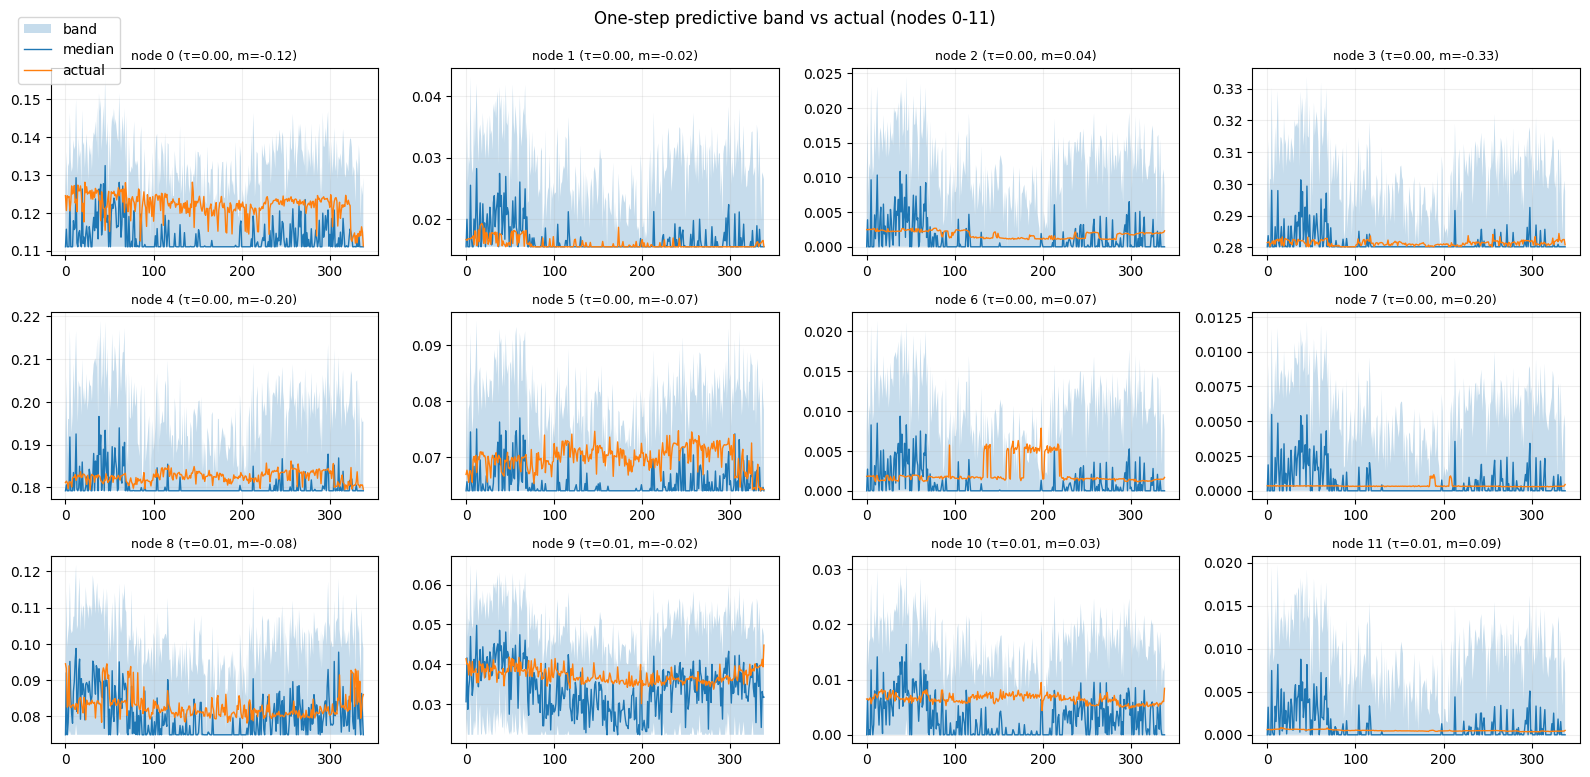

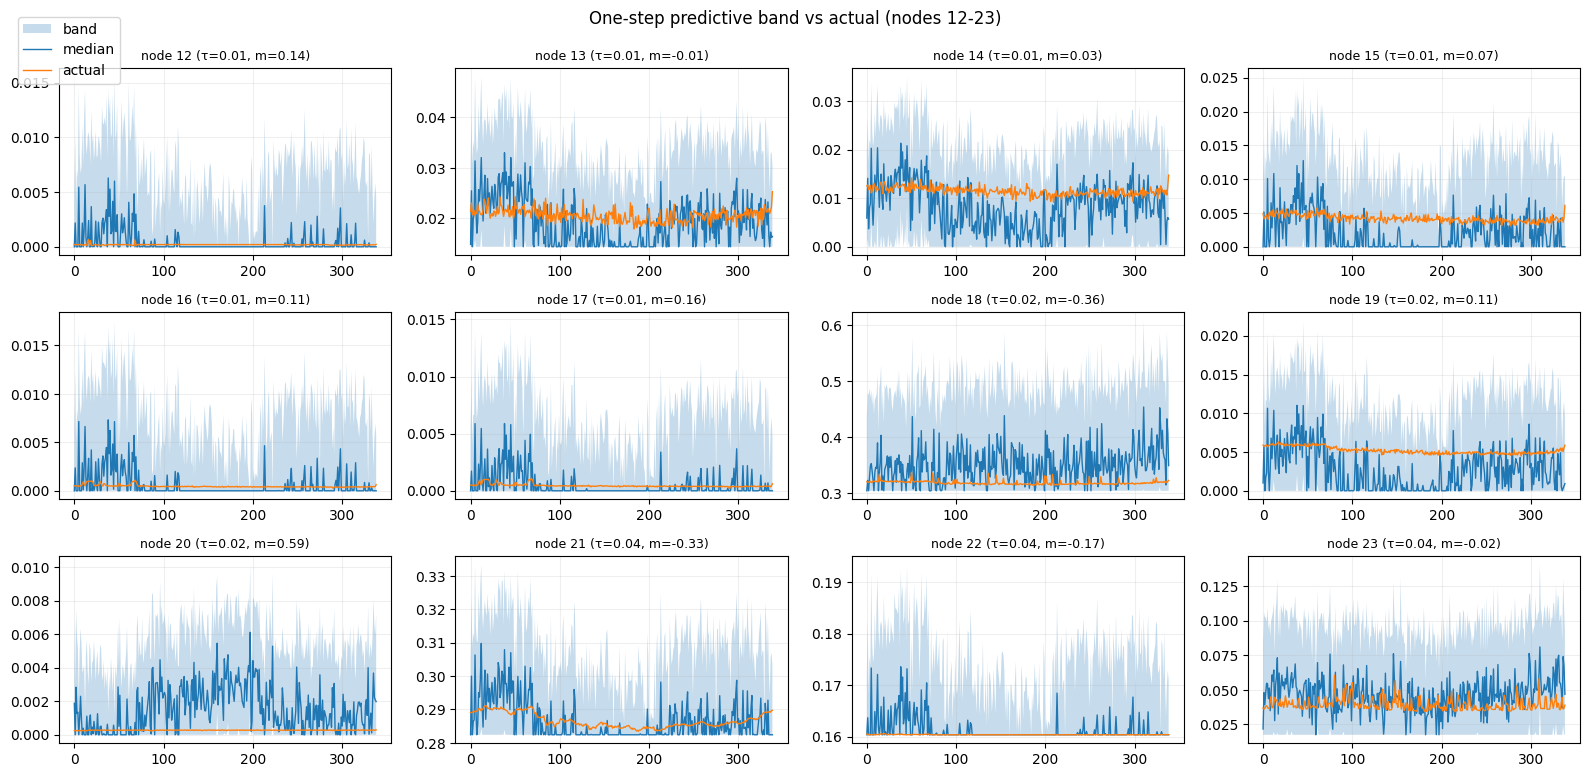

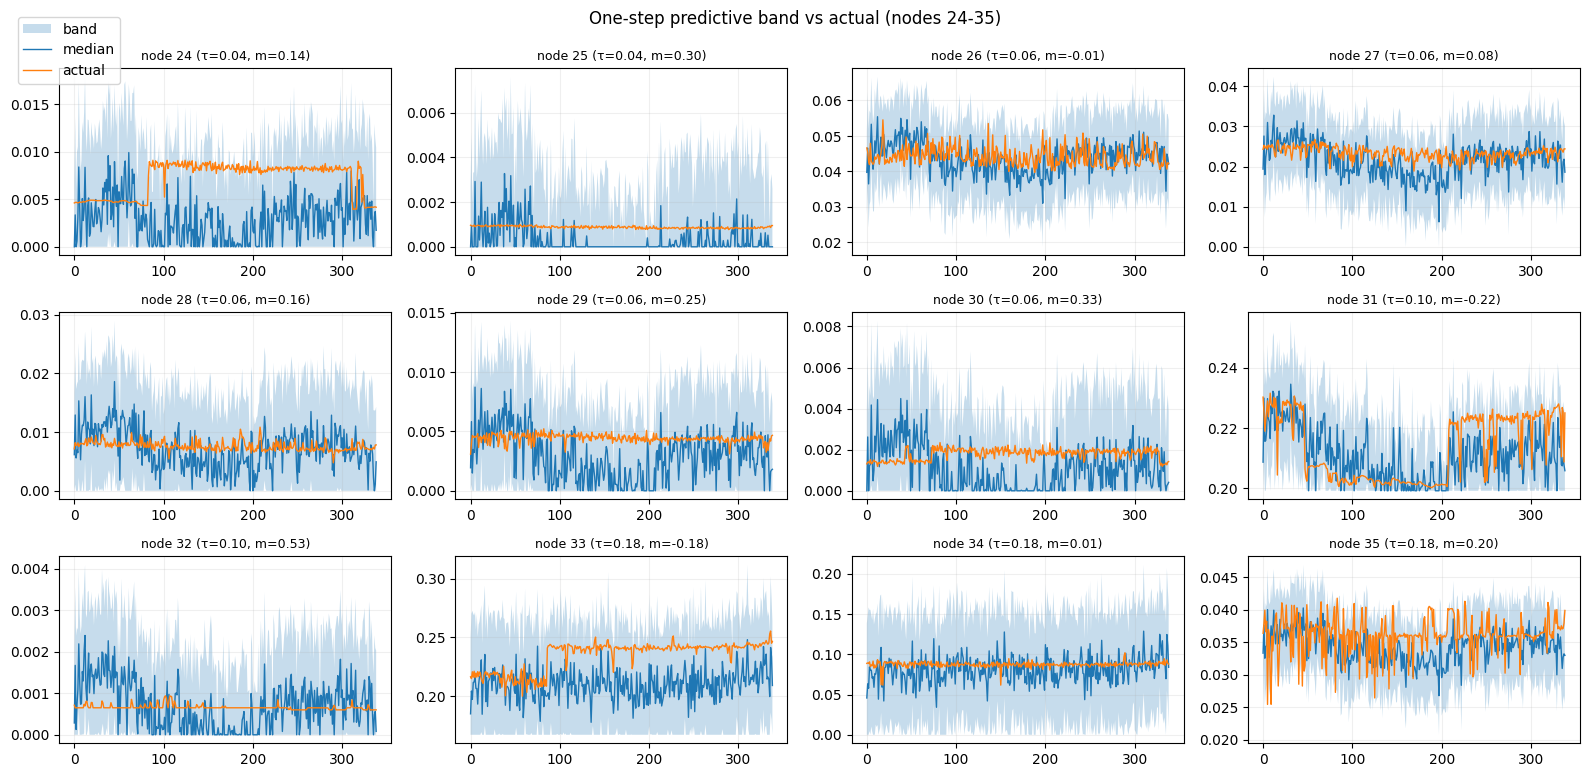

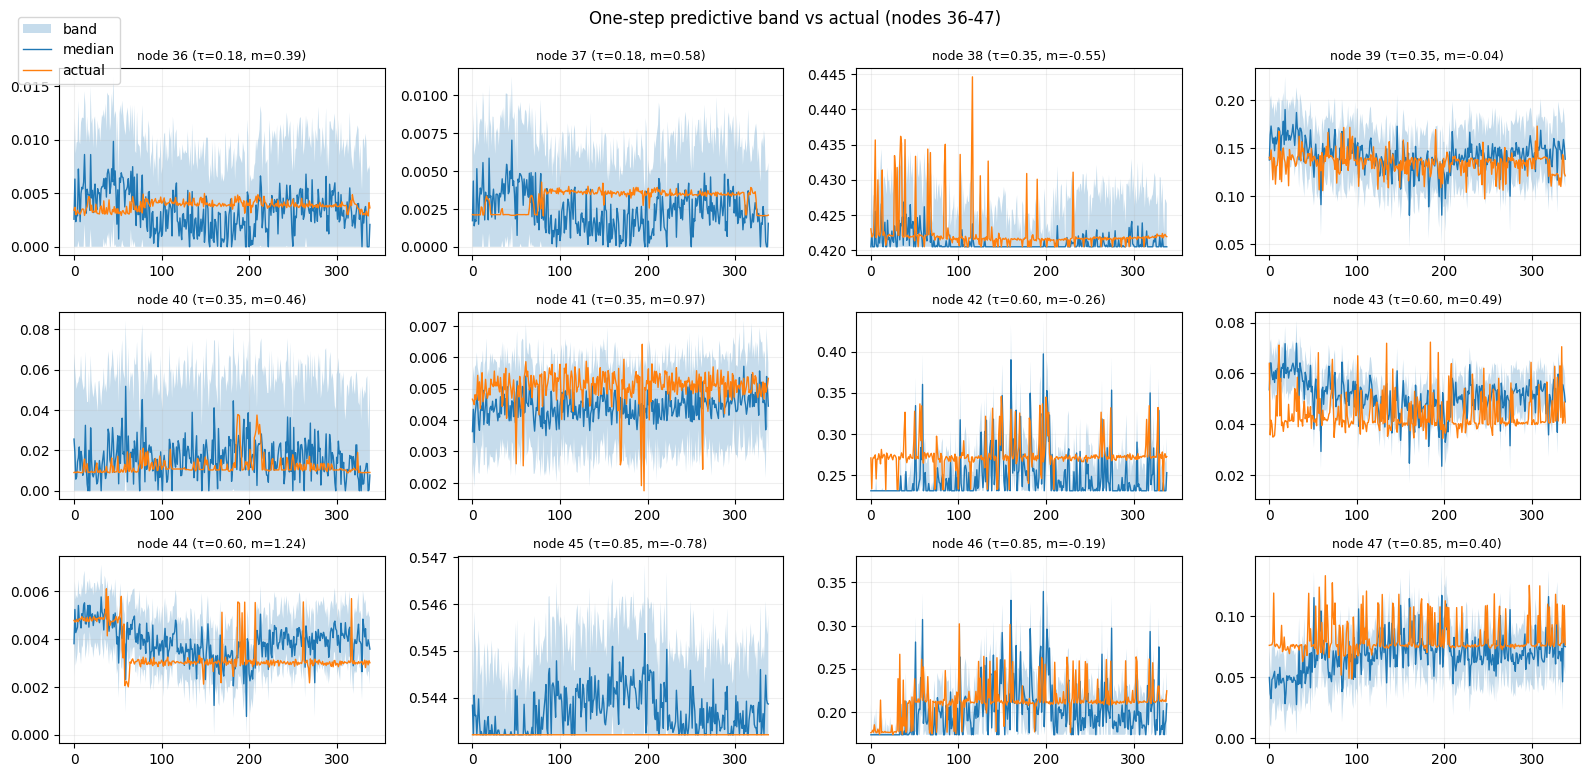

Mean coverage across nodes: 0.9018559488692232
Mean PIT mean across nodes: 0.5028156591844887


In [15]:
# ---------- align once ----------
sec_per_year = 1  
C_test = outs.C_test.values.astype(np.float64)           # (T_c, N)
idx_c  = pd.to_datetime(outs.C_test.index.values)
dt_years = np.asarray((idx_c[1:] - idx_c[:-1]).astype('timedelta64[s]'),
                      dtype=np.int64) / sec_per_year     # (T_c-1,)

_, X_te, _ = build_xi_training_data(outs)                # (T_x, p)
X_te = X_te.astype(np.float64)

steps = min(len(dt_years), X_te.shape[0], C_test.shape[0]-1)
N = outs.G0.shape[0]

# ---------- compute bands for ALL nodes ----------
def one_step_bands_all_nodes(model, X_te, dt_years, C_next, n_paths=1024, band=(0.06,0.94)):
    T = min(len(dt_years), X_te.shape[0], C_next.shape[0])
    q_lo = np.empty((T, N)); q_md = np.empty((T, N)); q_hi = np.empty((T, N))
    pits = np.empty((T, N))
    for t in range(T):
        C1_draws = one_step_draw_C(model, X_te[t], dt_years[t], n_paths=n_paths)  # (B, N)
        qs = np.quantile(C1_draws, [band[0], 0.5, band[1]], axis=0)               # (3, N)
        q_lo[t], q_md[t], q_hi[t] = qs[0], qs[1], qs[2]
        pits[t] = (C1_draws <= C_next[t]).mean(axis=0)
    return q_lo, q_md, q_hi, pits

q_lo, q_md, q_hi, pits = one_step_bands_all_nodes(
    model,
    X_te[:steps],
    dt_years[:steps],
    C_test[1:steps+1],          # actual at t+1
    n_paths=1024,
    band=(0.4, 0.6)         # ~89% like your plot
)

# ---------- small-multiple plots over nodes ----------
nodes_2d = getattr(outs, 'nodes_sub', getattr(outs, 'nodes_sub'))  # (N,2) [tau, m]

def plot_bands_grid(q_lo, q_md, q_hi, actual, nodes_2d, cols=4, rows=3):
    T, N = q_lo.shape
    idx = np.arange(T)
    per_fig = cols*rows
    for start in range(0, N, per_fig):
        end = min(start+per_fig, N)
        m = end - start
        r = math.ceil(m/cols)
        fig, axes = plt.subplots(r, cols, figsize=(cols*4.0, r*2.6), squeeze=False)
        axes = axes.ravel()
        for k, j in enumerate(range(start, end)):
            ax = axes[k]
            ax.fill_between(idx, q_lo[:, j], q_hi[:, j], alpha=0.25, label='band' if k==0 else None)
            ax.plot(idx, q_md[:, j], lw=1.0, label='median' if k==0 else None)
            ax.plot(idx, actual[:, j], lw=1.0, label='actual' if k==0 else None)
            tau, moneyness = nodes_2d[j, 0], nodes_2d[j, 1]
            ax.set_title(f"node {j} (τ={tau:.2f}, m={moneyness:.2f})", fontsize=9)
            ax.grid(alpha=0.2)
        # remove empty axes
        for k in range(m, len(axes)):
            fig.delaxes(axes[k])
        handles, labels = axes[0].get_legend_handles_labels()
        if handles:
            fig.legend(handles, labels, loc='upper left', bbox_to_anchor=(0.01, 0.99))
        fig.suptitle(f"One-step predictive band vs actual (nodes {start}-{end-1})", y=0.99)
        plt.tight_layout(); plt.show()

plot_bands_grid(q_lo, q_md, q_hi, C_test[1:steps+1], nodes_2d, cols=4, rows=3)

# ---------- optional: per-node calibration summary ----------
coverage = ((C_test[1:steps+1] >= q_lo) & (C_test[1:steps+1] <= q_hi)).mean(axis=0)   # (N,)
pit_mean = pits.mean(axis=0)                                                          # (N,)
print("Mean coverage across nodes:", float(coverage.mean()))
print("Mean PIT mean across nodes:", float(pit_mean.mean()))